In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib
import logging
import os
import nevergrad as ng
from concurrent import futures
import time
import networkx as nx
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
import sklearn.svm as svm
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

logger = logging.getLogger(__name__)
logging.basicConfig(level=os.environ.get("LOGLEVEL", "WARNING"))

from common import *
from helpers import *

RK Toolkit 0.0.1b


In [2]:
df = make_df_from_sheet(r"data/GWTC_2021_Master.csv") # read the file
df.head(n=1)

,id (Event ID),commonName (Event Name),Classification,version,catalog.shortName,GPS,Mass_1_source (solar masses),mass_1_source_upper_error,Mass_1_Upper Limit (solar masses),mass_1_source_lower_error,...,redshift_upper_limit,far,far_lower,far_upper,p_astro,p_astro_lower,p_astro_upper,final_mass_source,final_mass_source_lower,final_mass_source_upper
0,GW150914-v3,GW150914,Black Hole (High Mass),3,GWTC-1-confident,1126259462,35.6,4.7,40.3,-3.1,...,0.12,1.000000e-07,NaN,NaN,1.0,NaN,NaN,63.1,-3.0,3.4


In [3]:
def filter_bh(df): 
    # returns indexes of bh items
    return df.Classification.str.contains("Black Hole")

def filter_ns(df):
    return df.Classification.str.contains("Neutron Star")

/Users/akmb2/miniforge3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1061: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


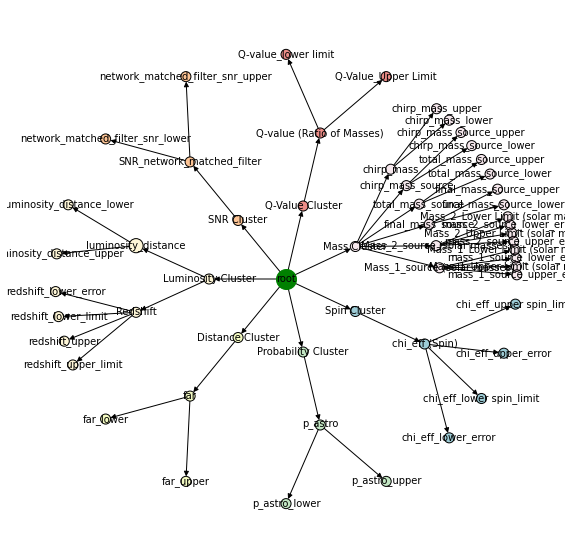

In [4]:
# load the heirarchy file.
from rktoolkit.functions.htg_transformers import BaseOntologyTransform
from rktoolkit.visualizers.util import draw_graph

hierarchy_file = r'data/gwtc_heirarchy_pretty.json'
hft = BaseOntologyTransform(mapping=json.load(open(hierarchy_file, "r")))
processed_df, y, alldf, ids = preprocess(df)

# plot the heirarchy
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
g = hft.transform(processed_df.iloc[0])
draw_graph(g , ax=ax, with_labels=True, minsize=100, alpha=100, emult=2, make_axis=False) 
os.makedirs("rendered", exist_ok=True)
plt.savefig("rendered/heirarchy_graph.png")

In [5]:
opts = {
    "chi_eff (Spin)": [-0.1, 0.1],
    "Q-value (Ratio of Masses)": [.01, .88]
}
import numbers
from rktoolkit.functions.filters import RangeFilter
from rktoolkit.functions.linkers import SimpleChildLinker

def make_linkers_and_filters(graph, opts={}):
    '''
    Defaults all filters to be a range filter. And the linker to be a simple child linker. 
    '''
    ENDL = " | " 
    filters, linkers = {}, {}
    for k, v in graph.nodes.items():
        if 'value' in v and isinstance(v['value'], numbers.Number):
            if v["id"] in opts:
                print("Set {:s} from options".format(v["id"]), end=ENDL)
            else:
                print("Set {:s} to default".format(v["id"]), end=ENDL)
            minv, maxv = opts.get(v["id"][0], 0), opts.get(v["id"][1], 1)
            filters[k] = RangeFilter(min=minv, max=maxv)        
    linkers['root'] = SimpleChildLinker()
    return filters, linkers

filters, linkers = make_linkers_and_filters(g, opts)

Set Mass_1_source (solar masses) to default | Set mass_1_source_upper_error to default | Set Mass_1_Upper Limit (solar masses) to default | Set mass_1_source_lower_error to default | Set Mass_1_Lower Limit (solar masses) to default | Set mass_2_source_upper_error to default | Set final_mass_source to default | Set final_mass_source_lower to default | Set final_mass_source_upper to default | Set total_mass_source to default | Set total_mass_source_lower to default | Set total_mass_source_upper to default | Set chirp_mass_source to default | Set chirp_mass_source_lower to default | Set chirp_mass_source_upper to default | Set chirp_mass to default | Set chirp_mass_lower to default | Set chirp_mass_upper to default | Set Q-value (Ratio of Masses) from options | Set Q-Value_Upper Limit to default | Set Q-value_lower limit to default | Set SNR_network_matched_filter to default | Set network_matched_filter_snr_upper to default | Set network_matched_filter_snr_lower to default | Set luminosit

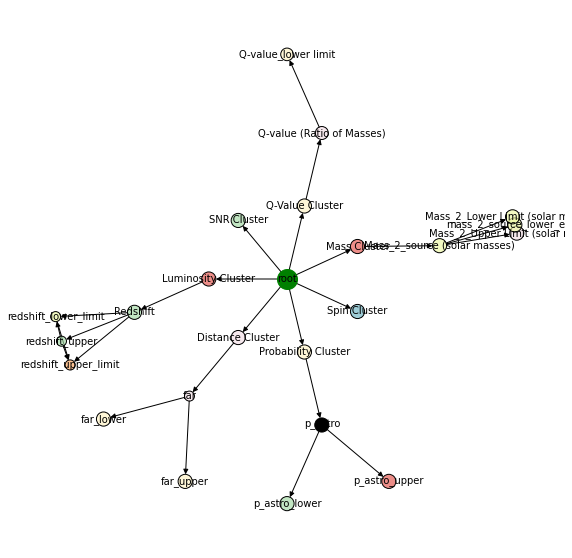

In [6]:
from rktoolkit.models.pipeline import RKPipeline 
from rktoolkit.visualizers.util import draw_rk_diagram
from rktoolkit.models.graph import Edge 

pipeline = RKPipeline(filter_map=filters, linkage_map=linkers, structural_graph=g)
g2 = pipeline.transform(g, is_base=False)
fig, ax = plt.subplots(figsize=(10,10))
draw_rk_diagram(g2, ax=ax, with_labels=True, minsize=100, alpha=100, emult=2, make_axis=False)  
plt.savefig("rendered/rk_graph1.png")

## Untuned Visualizations

Set Mass_1_source (solar masses) to default | Set mass_1_source_upper_error to default | Set Mass_1_Upper Limit (solar masses) to default | Set mass_1_source_lower_error to default | Set Mass_1_Lower Limit (solar masses) to default | Set mass_2_source_upper_error to default | Set final_mass_source to default | Set final_mass_source_lower to default | Set final_mass_source_upper to default | Set total_mass_source to default | Set total_mass_source_lower to default | Set total_mass_source_upper to default | Set chirp_mass_source to default | Set chirp_mass_source_lower to default | Set chirp_mass_source_upper to default | Set chirp_mass to default | Set chirp_mass_lower to default | Set chirp_mass_upper to default | Set Q-value (Ratio of Masses) to default | Set Q-Value_Upper Limit to default | Set Q-value_lower limit to default | Set SNR_network_matched_filter to default | Set network_matched_filter_snr_upper to default | Set network_matched_filter_snr_lower to default | Set luminosity_

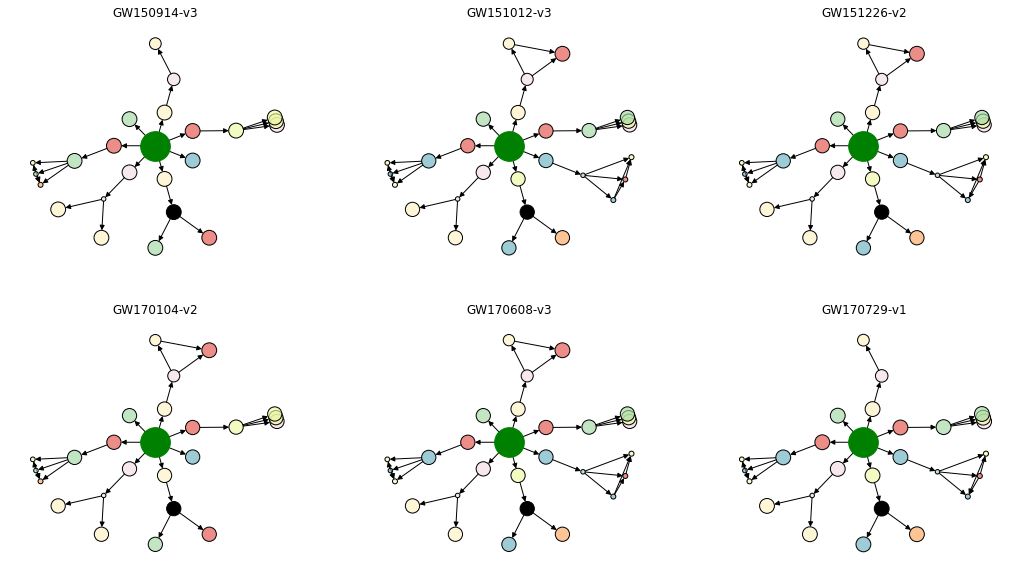

In [7]:
# completely untuned
f, l = make_linkers_and_filters(g, {})
n = 6
pipeline = RKPipeline(filter_map=f, linkage_map=l, structural_graph=g)
rkmodels = make_n_rkmodels(processed_df, alldf, hft, pipeline, n=n)
mdist = compute_distance(processed_df)
distances = compute_distances(rkmodels, mdist, w=[.5,.5])
visualize_n(rkmodels, n=n, minsize=20, alpha=200, emult=4, with_labels=False)
plt.savefig("rendered/untuned_{}.png".format(n))
print("Average similarity of graphs pre tuned: {}".format(1 - np.mean(distances)))

Average similarity of graphs pre tuned: 0.9305839375818552


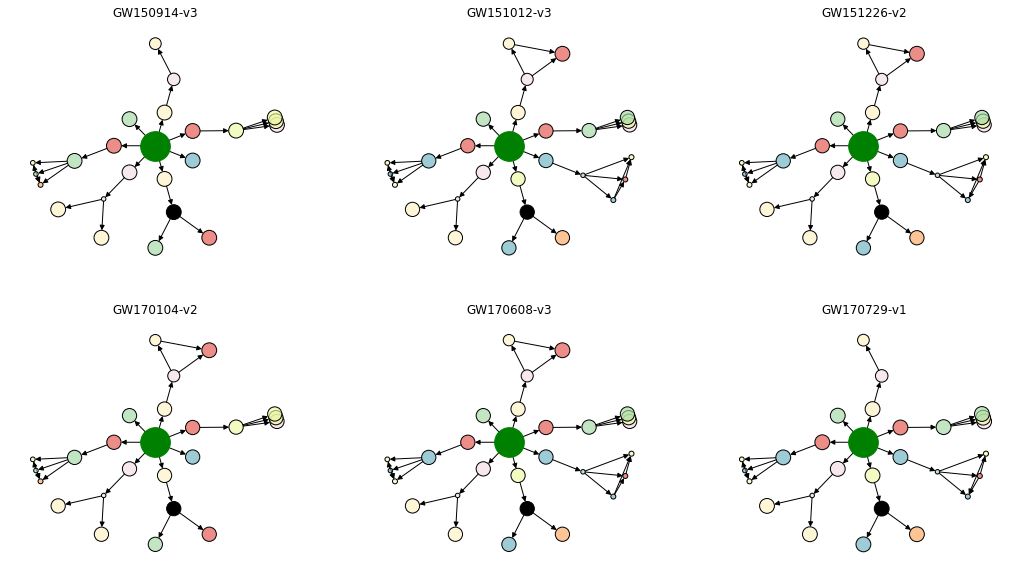

In [8]:
n = 6
pipeline = RKPipeline(filter_map=filters, linkage_map=linkers, structural_graph=g)
rkmodels = make_n_rkmodels(processed_df, alldf, hft, pipeline, n=n)
mdist = compute_distance(processed_df)
distances = compute_distances(rkmodels, mdist, w=[.5,.5])
visualize_n(rkmodels, n=n, minsize=20, alpha=200, emult=4, with_labels=False)
plt.savefig("rendered/untuned_{}.png".format(n))
print("Average similarity of graphs pre tuned: {}".format(1 - np.mean(distances)))

In [9]:
selected_events = ["GW170729", "GW170817", "GW190814", "GW190521"]
subset_df = df[df["commonName (Event Name)"].isin(selected_events)]
label_df = df.iloc[subset_df.index]

def build_4_model(pipeline, title, filename):
    n = 4
    rkmodels = make_n_rkmodels(processed_df, alldf,hft, pipeline, n=n, indexes=list(subset_df.index))
    print("Processed {} rk models from {}".format(len(rkmodels), len(processed_df)))
    mdist = compute_distance(processed_df)
    distances = compute_distances(rkmodels, mdist, w=[.5,.5])
    visualize_n(rkmodels, n=n, minsize=20, alpha=200, emult=4, with_labels=False)
    
    plt.savefig("rendered/untuned_{}_{}.png".format(filename, n))
    plt.show()
    print("Average similarity of graphs pre tuned: {}".format(1 - np.mean(distances)))

## Tuning

Iteration: 00100. Loss: 0.94509804. ITime 6.24 seconds. Total time: 6.36
Iteration: 00200. Loss: 0.91825397. ITime 6.48 seconds. Total time: 12.84
Iteration: 00300. Loss: 0.90267000. ITime 6.61 seconds. Total time: 19.45
Iteration: 00400. Loss: 0.89582808. ITime 6.50 seconds. Total time: 25.95
Iteration: 00500. Loss: 0.87988594. ITime 6.55 seconds. Total time: 32.50
Iteration: 00600. Loss: 0.92906266. ITime 6.65 seconds. Total time: 39.15
Iteration: 00700. Loss: 0.88783736. ITime 6.67 seconds. Total time: 45.82
Iteration: 00800. Loss: 0.92518613. ITime 6.85 seconds. Total time: 52.67
Iteration: 00900. Loss: 0.92272765. ITime 6.55 seconds. Total time: 59.22
Iteration: 01000. Loss: 0.88411593. ITime 6.72 seconds. Total time: 65.94
Iteration: 01100. Loss: 0.90092668. ITime 6.69 seconds. Total time: 72.62
Iteration: 01200. Loss: 0.89094607. ITime 6.61 seconds. Total time: 79.23
Iteration: 01300. Loss: 0.88140951. ITime 6.59 seconds. Total time: 85.83
Iteration: 01400. Loss: 0.88584417. ITi

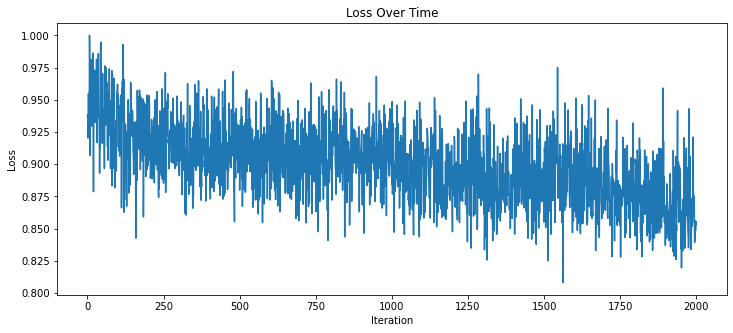

<Figure size 432x288 with 0 Axes>

In [10]:
w0 = pipeline.get_w()
weights, history = train(len(w0[0]), pipeline, processed_df, hft, mdist)
show(weights, history, pipeline, processed_df, hft, w0)

### Saving Weights and Loading Weights

In [23]:
def save_weights(directory="weights"):
    # overrides the weights file
    directory = "weights"
    if not os.path.exists(directory):
        os.makedirs(directory)
    np.savetxt('{}/weights.txt'.format(directory), weights)

def load_weights(path):
    return np.loadtxt(path)

#save_weights()
weights = load_weights("weights/weights.txt")

Average similarity of graphs tuned: 0.9305839375818552


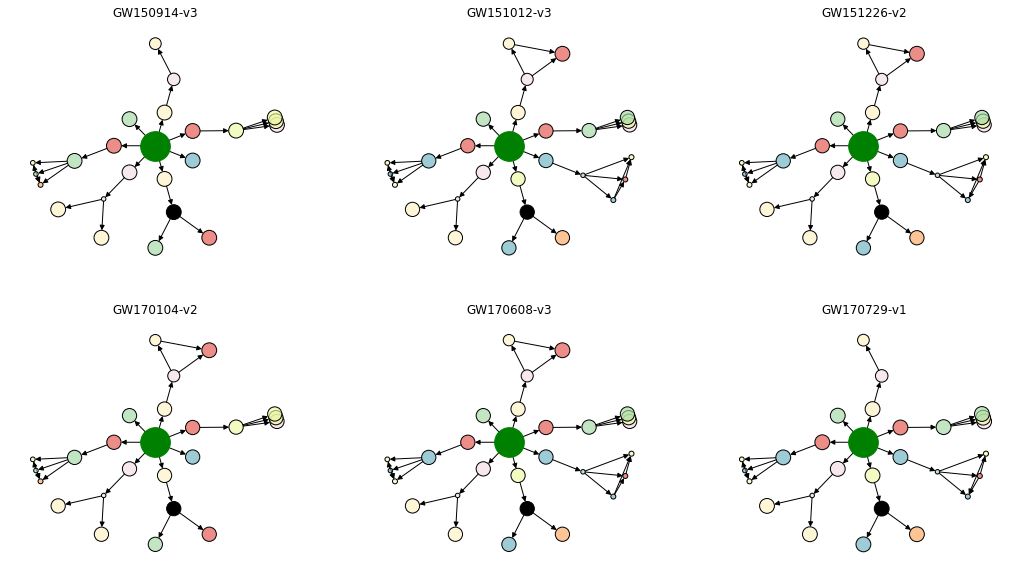

In [25]:
def run(filters, linkers, g, processed_df, alldf, hft, pipeline, n=6):
    pipeline = RKPipeline(filter_map=filters, linkage_map=linkers, structural_graph=g)
    rkmodels = make_n_rkmodels(processed_df, alldf, hft, pipeline, n=n)
    mdist = compute_distance(processed_df)
    distances = compute_distances(rkmodels, mdist, w=[.5,.5])
    visualize_n(rkmodels, n=n, minsize=20, alpha=200, emult=4, with_labels=False)
    plt.savefig("rendered/untuned_{}.png".format(n))
    print("Average similarity of graphs tuned: {}".format(1 - np.mean(distances)))
    
run(filters, linkers, g, processed_df, alldf, hft, pipeline)

### Classification

In [26]:
def build_classification_data(processed_df, y, alldf, hft, pipeline):
    n = len(processed_df)

    start = time.time()
    rkmodels = make_n_rkmodels(processed_df, alldf, hft, pipeline, n=n)
    t = time.time() - start
    print("Making rk models. Took {} seconds. {} seconds Per model".format(t, t/n))

    start = time.time()
    X = [ extract_rk_features(rk) for rk in rkmodels ]
    t = time.time() - start
    print("Extracted features. Took {} seconds. {} seconds Per model".format(t, t/n))
    return train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

def classify1(X_train, X_test, y_train, y_test):
    
    encoder = LabelEncoder()
    y = encoder.fit_transform(y_train.str.strip())
    
    clf = OneVsRestClassifier(
        svm.SVC(kernel="linear", probability=True, random_state=1)
    )

    clf.fit(X_train, y_train)
    predicted = clf.predict(X_test)

    y_score = clf.fit(X_train, y_train).decision_function(X_test)
    print(classification_report(y_test, predicted, target_names=encoder.classes_))
    
X_train, X_test, y_train, y_test = build_classification_data(processed_df, y, alldf, hft, pipeline)
classify1(X_train, X_test, y_train, y_test)

Making rk models. Took 0.19051074981689453 seconds. 0.0020935247232625773 seconds Per model
Extracted features. Took 3.4027950763702393 seconds. 0.037393352487585046 seconds Per model
                           precision    recall  f1-score   support

   Black Hole (High Mass)       0.70      0.89      0.78        18
    Black Hole (Low Mass)       0.40      0.29      0.33         7
             Neutron Star       0.00      0.00      0.00         1
Neutron Star + Black Hole       0.00      0.00      0.00         1
            PBH Candidate       0.00      0.00      0.00         1

                 accuracy                           0.64        28
                macro avg       0.22      0.23      0.22        28
             weighted avg       0.55      0.64      0.59        28



/Users/akmb2/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/akmb2/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/akmb2/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Working on subset Neutron Star
Set Mass_1_source (solar masses) to default | Set mass_1_source_upper_error to default | Set Mass_1_Upper Limit (solar masses) to default | Set mass_1_source_lower_error to default | Set Mass_1_Lower Limit (solar masses) to default | Set mass_2_source_upper_error to default | Set final_mass_source to default | Set final_mass_source_lower to default | Set final_mass_source_upper to default | Set total_mass_source to default | Set total_mass_source_lower to default | Set total_mass_source_upper to default | Set chirp_mass_source to default | Set chirp_mass_source_lower to default | Set chirp_mass_source_upper to default | Set chirp_mass to default | Set chirp_mass_lower to default | Set chirp_mass_upper to default | Set Q-value (Ratio of Masses) to default | Set Q-Value_Upper Limit to default | Set Q-value_lower limit to default | Set SNR_network_matched_filter to default | Set network_matched_filter_snr_upper to default | Set network_matched_filter_snr_low

/Users/akmb2/miniforge3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1061: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


Processed 5 rk models from 5
Average similarity Untuned + Domain Expertise: 0.8275136883484946
Processed 5 rk models from 5
Average similarity Tuned + Domain Expertise: 0.8255369038940275
Working on subset Black Hole
Set Mass_1_source (solar masses) to default | Set mass_1_source_upper_error to default | Set Mass_1_Upper Limit (solar masses) to default | Set mass_1_source_lower_error to default | Set Mass_1_Lower Limit (solar masses) to default | Set mass_2_source_upper_error to default | Set final_mass_source to default | Set final_mass_source_lower to default | Set final_mass_source_upper to default | Set total_mass_source to default | Set total_mass_source_lower to default | Set total_mass_source_upper to default | Set chirp_mass_source to default | Set chirp_mass_source_lower to default | Set chirp_mass_source_upper to default | Set chirp_mass to default | Set chirp_mass_lower to default | Set chirp_mass_upper to default | Set Q-value (Ratio of Masses) to default | Set Q-Value_Uppe

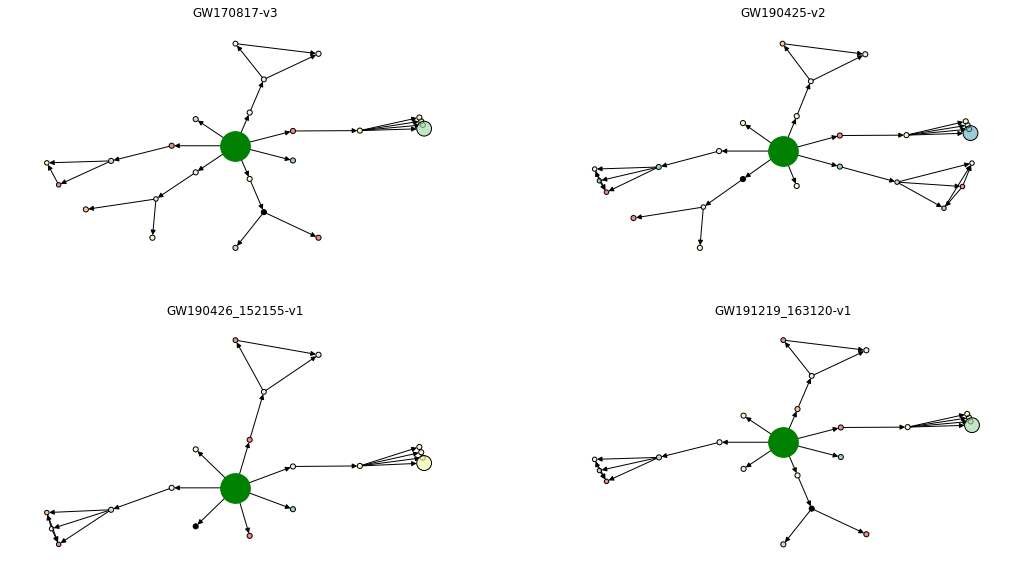

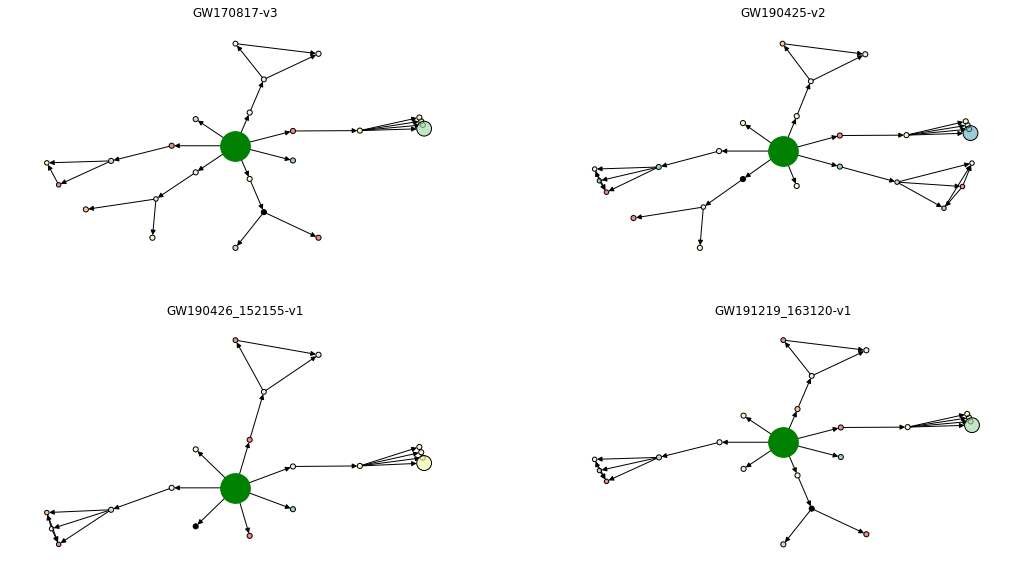

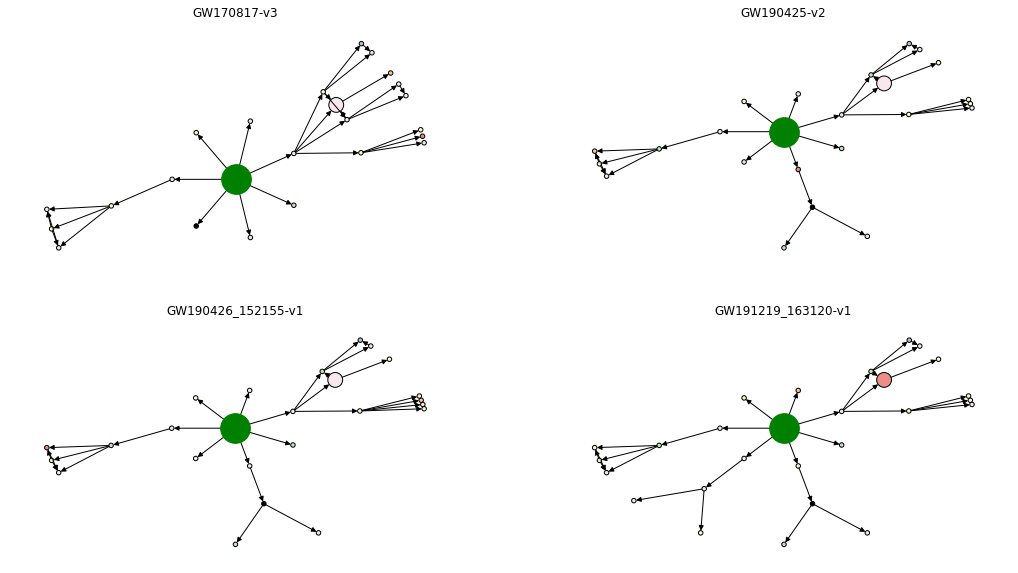

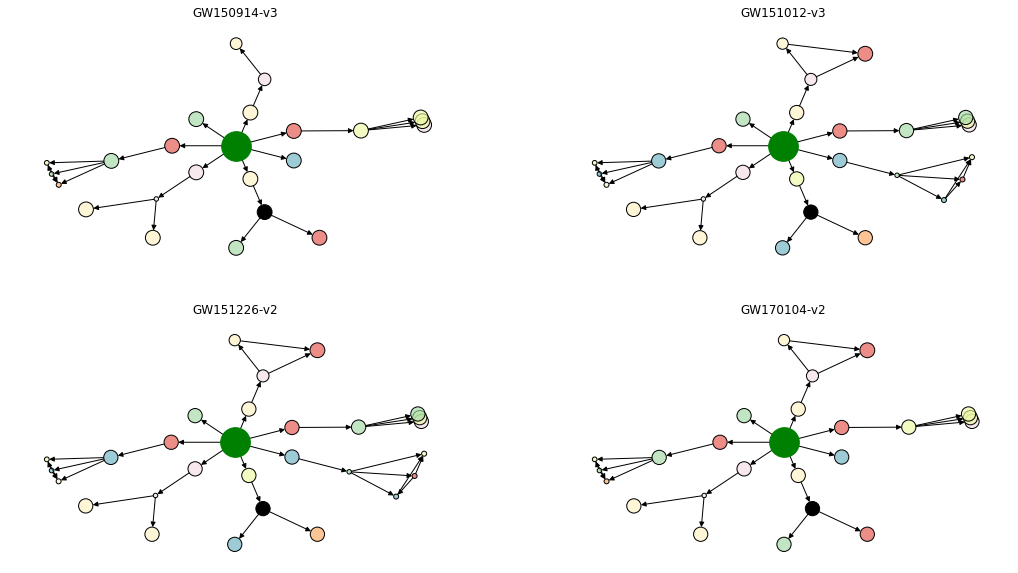

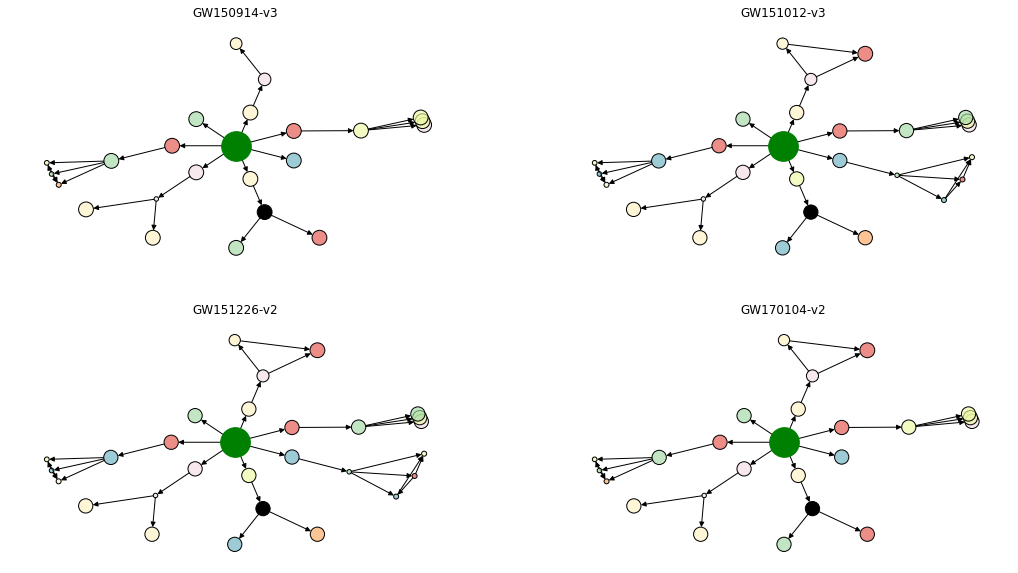

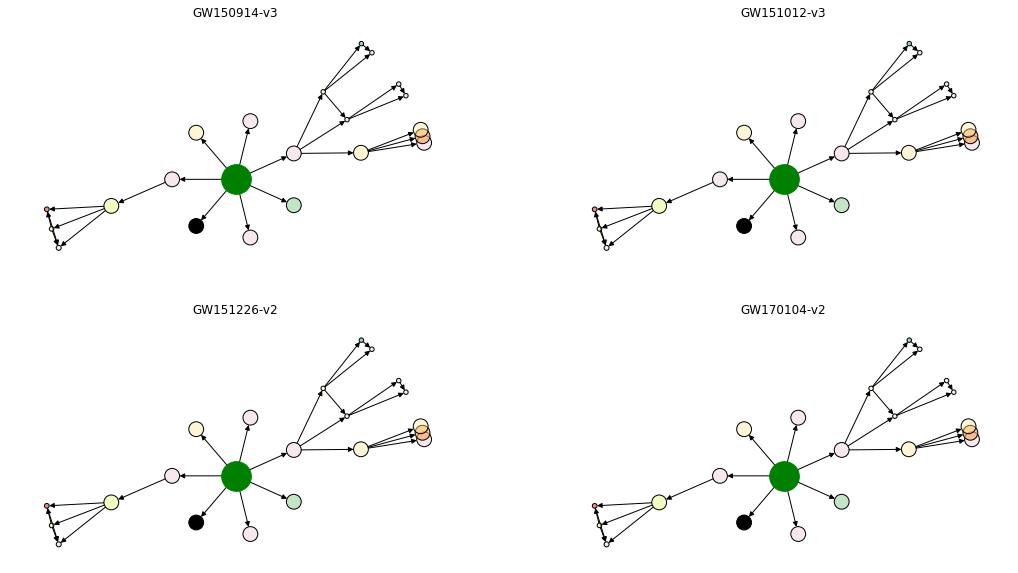

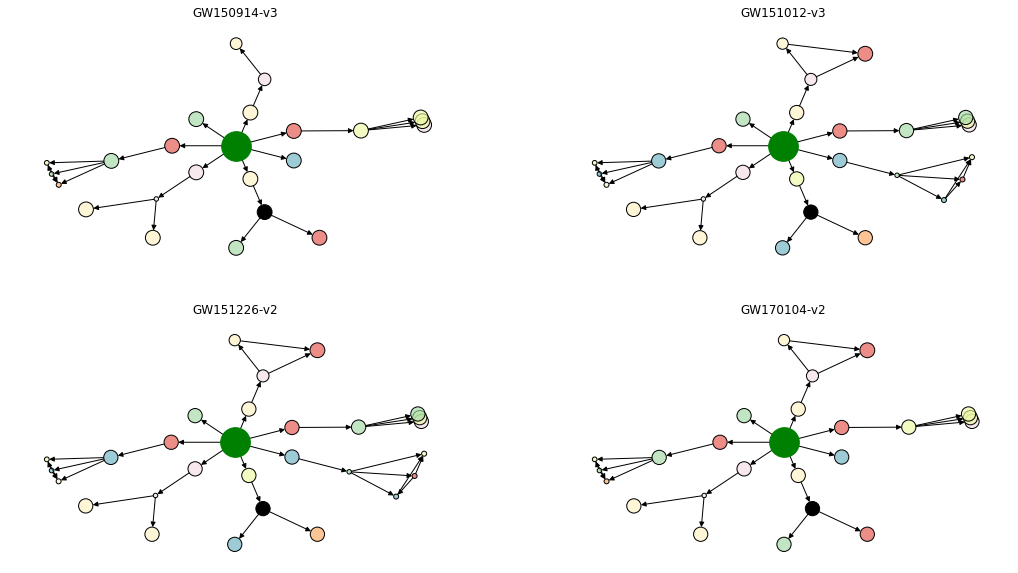

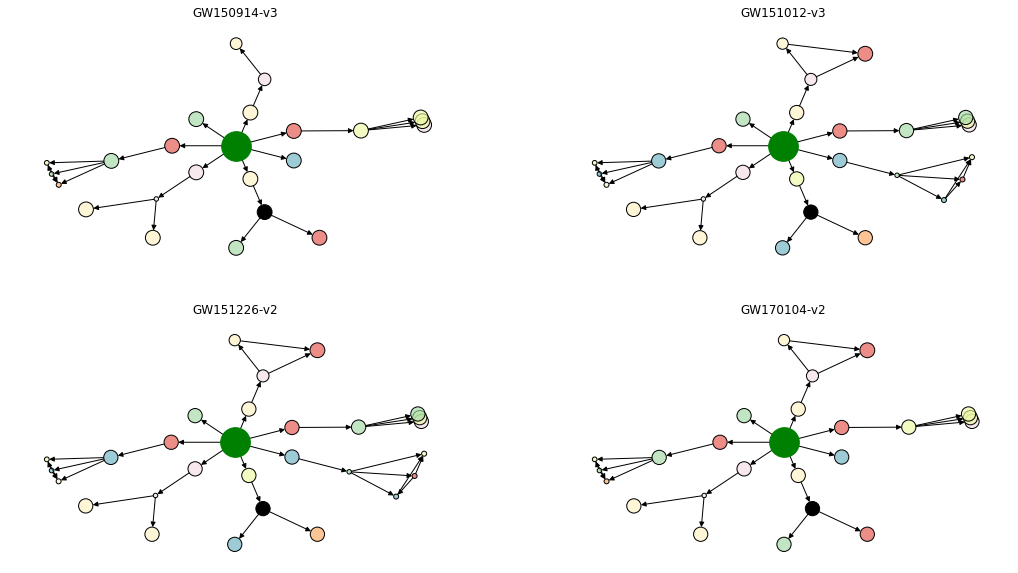

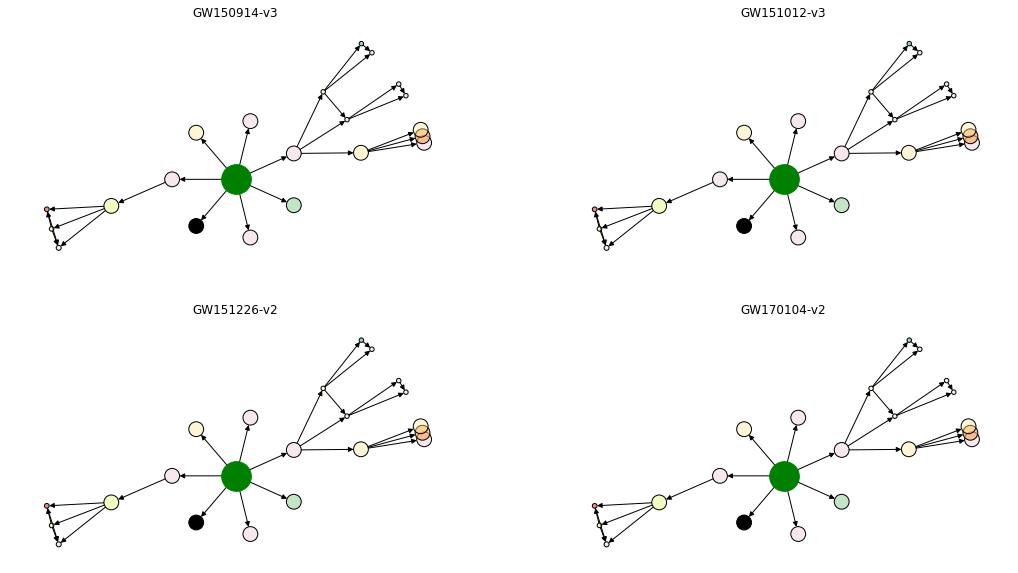

In [27]:
subsets = [ ("Neutron Star", filter_ns(df),y_train.str.contains("Neutron Star"), y_test.str.contains("Neutron Star")),
            ("Black Hole", filter_bh(df),y_train.str.contains("Black Hole"), y_test.str.contains("Black Hole")),
            ("All", [True] * len(df), [True] * len(y_train), [True] * len(y_test))]
#subsets = subsets[0]

def print_bold(s):
    print('\033[1m' + s + '\033[0m')
    
def show_models(pipeline, title, filename, processed_df, alldf, hft, n=4):
    subset_df = alldf
    rkmodels = make_n_rkmodels(processed_df, alldf,hft, pipeline, n=n, indexes=range(0,len(alldf)))
    print_bold("Processed {} rk models from {}".format(len(rkmodels), len(processed_df)))
    mdist = compute_distance(processed_df)
    distances = compute_distances(rkmodels, mdist, w=[.5,.5])
    visualize_n(rkmodels, n=n, minsize=20, alpha=200, emult=4, with_labels=False)
    #plt.savefig("rendered/untuned_{}_{}.png".format(filename, n))
    #plt.show()
    print_bold("Average similarity {}: {}".format(title, 1 - np.mean(distances)))
    
for s in subsets:
    print_bold("Working on subset " + s[0])
    pdf2 = processed_df[s[1]]
    df2 = df[s[1]]
    f, l = make_linkers_and_filters(g, {})
    untuned_pipeline = RKPipeline(filter_map=f, linkage_map=l, structural_graph=g)
    show_models(untuned_pipeline, "Untuned + No Domain Expertise ", s[0] + "_untuned_no_domain_expertise", processed_df=pdf2, alldf=df2, hft=hft )
    pipeline = RKPipeline(filter_map=filters, linkage_map=linkers, structural_graph=g)
    show_models(pipeline, "Untuned + Domain Expertise", s[0] + "_untuned_domain_expertise", processed_df=pdf2, alldf=df2, hft=hft )
    show_models(pipeline.remap(weights, w0[1]),  "Tuned + Domain Expertise", s[0] + "_tuned_domain_expertise", processed_df=pdf2, alldf=df2, hft=hft )


## Embedding

This is a quick and dirty way to embed an RK Diagram into space.

1. Get positions of TSNE embedding for the processed numerical data.
2. Impose in 2D space RK-Diagrams, giving ND representations into 2D space. 

In [60]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

import numpy as np

# create a list of subsets to view 
subset_x = []
for x in y.unique():
    subset_x.extend(np.where(y == x)[0][:2])

pre_embedded = processed_df.iloc[subset_x]
selected_labels = y[subset_x]

X_embedded = TSNE(n_components=2, init='random', perplexity=4).fit_transform(processed_df.astype(np.float64))
X_embedded = MinMaxScaler().fit_transform(X_embedded)

/Users/akmb2/miniforge3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1061: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)
<ipython-input-149-02fe3d6bd45c>:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.round(np.array(np.arange(-10, 10, 2.7)),2), fontsize=8)
<ipython-input-149-02fe3d6bd45c>:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.round(np.array(np.arange(-11.5, 10, 2.5)),2), fontsize=8)


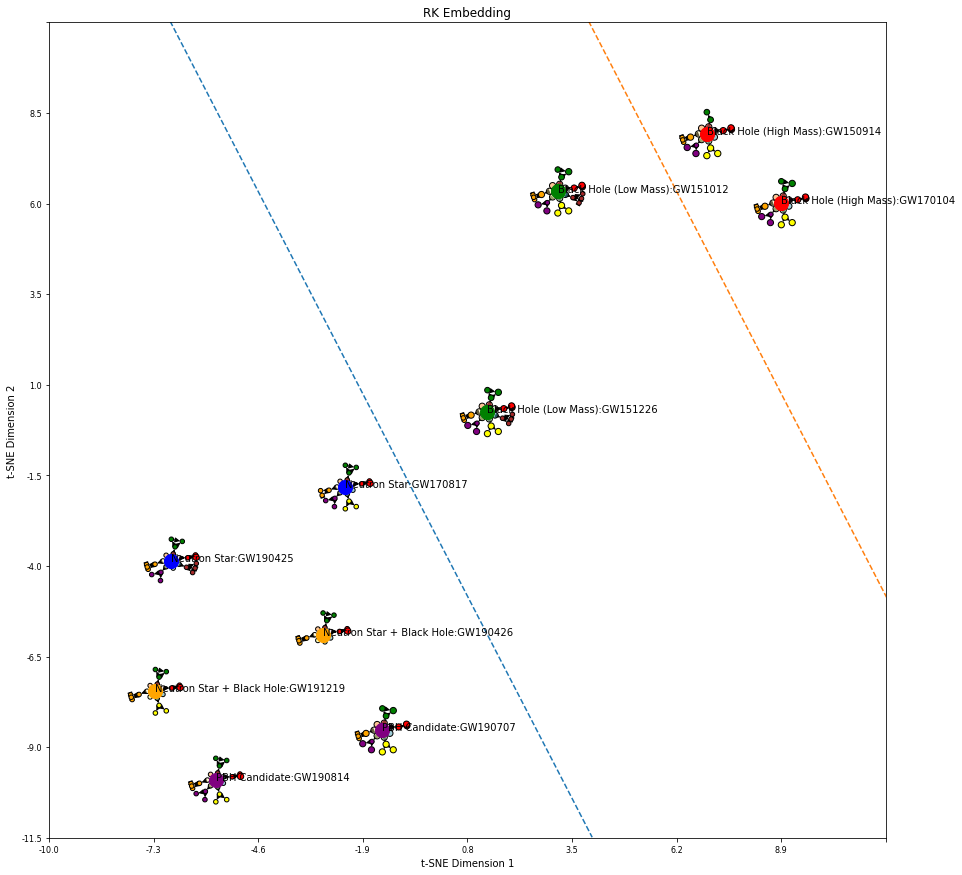

In [149]:
from sklearn import preprocessing
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.ticker import FormatStrFormatter

def embed_rkdiagrams(subset_idxs,embedded_data, df, y, spread=100):
    placements = []
    fig, ax = plt.subplots(figsize=(15,15))
    le = preprocessing.LabelEncoder().fit_transform(y)
    colors = ["red", "green", "blue", "orange", 'purple', 'yellow', 'brown']
    children = pipeline.structural_graph.get_children('root')

    for i, idx in enumerate(subset_idxs): 
        
        pos = embedded_data[i]
        data = processed_df.iloc[idx]
        name = df['commonName (Event Name)'].iloc[idx].split("_")[0]
        label = selected_labels.iloc[i]

        base = hft.transform(data)
        rkm = pipeline.transform(base, is_base=False)
        for i, c in enumerate(children):
            for _, cn in enumerate(rkm.G.get_children(c, recursive=True)):
                 rkm.G.nodes[cn]['color'] = colors[i]
                    
        draw_rk_diagram2(rkm, ax=ax, with_labels=False,
                         spread=2, 
                         center_color=colors[le[idx]],
                         xoff=pos[0]*spread, 
                         yoff=pos[1]*spread, 
                         minsize=20, alpha=20, 
                         emult=5, make_axis=False)  
    
        ax.text(pos[0]*spread, pos[1]*spread, "{}:{}".format(label, name))
        placements.append(pos * spread)
    
    # directly place lines for visuals. 
    # this was requested for demonstration purposes.
    # line was manually determined.
    l1 = np.array([[470.44, 155.85],[ 490.96,110.03]])
    plt.plot(l1[:,0], l1[:,1], '--'	)
  
    l1 = np.array([[490.44, 155.85],[ 510.96,110.03]])
    plt.plot(l1[:,0], l1[:,1], '--'	)
    
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    limits=plt.axis('on') # turns on axis

    ax.set_xlabel("t-SNE Dimension 1")
    ax.set_ylabel("t-SNE Dimension 2")
    ax.set_xlim([465, 505])
    ax.set_ylim([110, 155])

    np.set_printoptions(precision=2)
    ax.set_xticklabels(np.round(np.array(np.arange(-10, 10, 2.7)),2), fontsize=8)
    ax.set_yticklabels(np.round(np.array(np.arange(-11.5, 10, 2.5)),2), fontsize=8)

    plt.title("RK Embedding")
    plt.show()
    
embed_rkdiagrams(subset_x, X_embedded, df, y, spread=500 )

In [35]:
import math 
from rktoolkit.visualizers.networkx.dendrogram import hierarchy_pos

    
def draw_rk_diagram2(rkmodel, ax=None, with_labels=True, minsize=100, center_color='green', spread=1,
                    alpha=300, emult=2, make_axis=False, width=2*math.pi, xoff=0, yoff=0, color_override=None):
    if make_axis:
        fig, ax = plt.subplots(figsize=(10,10))

    if ax is None:
        ax = plt.gca()
    
    # indexing
    nodes = list(rkmodel.G.nodes)
    g = rkmodel.get()
    node_subset = list(g.nodes)
    selected_indexes = [nodes.index(n) for n in node_subset]
    
    # positioning
    structural_pos = hierarchy_pos(rkmodel.G, 'root', width = width, xcenter=0)
    structural_pos = {u:(r*math.cos(theta)*spread,r*math.sin(theta)*spread) for u, (theta, r) in structural_pos.items()}
   
    # color 
    structural_colors = [ rkmodel.G.nodes[n].get('color','black') for n in nodes]
    filtered_colors = [structural_colors[i] for i in selected_indexes]
    if color_override is not None:
        if isinstance(color_override, str):
            filtered_colors = [color_override] * len(filtered_colors)

    # filter node to only ones that show after getting the rkm
    filtered_pos = {k: structural_pos[k] for k in node_subset}
    
    # update 
    for k,v in filtered_pos.items():
        filtered_pos[k] = [v[0]+xoff, v[1]+yoff]

    def _get_sizes(subset, defaultN=1, minsize=1):
        # convert all nodes into numeric values
        sizes = []
        for n in node_subset:
            v = rkmodel.G.nodes[n].get("value", 1)
            if not isinstance(v, numbers.Number):
                v = defaultN
            v+=minsize
            sizes.append(v)
        return sizes
    
    def _resize(sizes):
        sizes = np.array(sizes)
        sizes = sizes ** 5 #np.exp(sizes)
        sizes = (sizes - sizes.min()) / (sizes.max()-sizes.min())
        sizes *= alpha
        sizes += minsize
        sizes = np.where(np.isnan(sizes), minsize, sizes)
        return sizes

    sizes = _get_sizes(node_subset)
    sizes = _resize(sizes)
   
    nx.draw(g, pos=filtered_pos, with_labels=with_labels,
            font_size=10, node_size=sizes, ax=ax, node_color = filtered_colors, edgecolors = 'black')

    nx.draw_networkx_nodes(g, pos=filtered_pos, nodelist = ['root'],
                           node_color = center_color, ax=ax, node_size = sizes.max()*emult)


Making rk models. Took 0.39420413970947266 seconds. 0.004331913623181018 seconds Per model
Extracted features. Took 3.8476779460906982 seconds. 0.04228217523176592 seconds Per model


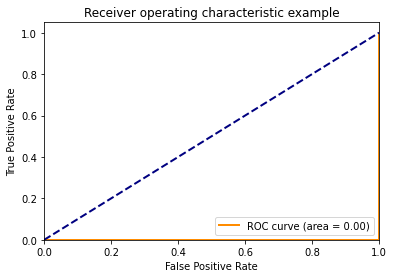

In [221]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score


def roc_auc_visualization():
    classes = y.str.strip()
    y_b = label_binarize(classes, classes=list(np.unique(classes)))
    X_train, X_test, y_train, y_test = build_classification_data(processed_df, y_b, alldf, hft, pipeline)

    clf = OneVsRestClassifier(
        svm.SVC(kernel="linear", probability=True, random_state=1)
    )


    y_score = clf.fit(X_train, y_train).decision_function(X_test)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(np.unique(classes))):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure()
    lw = 2
    plt.plot(
        fpr[2],
        tpr[2],
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc[2],
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()
    
roc_auc_visualization()

### Interclass Similarity Scores

Initial method is pretty primative.

1. Subset data in the class
2. Take the averages of each subset
3. Convert that to an RK Model as the "class" model
4. Find the distances X classes

0 0
1 0
0 1
1 1
0 2


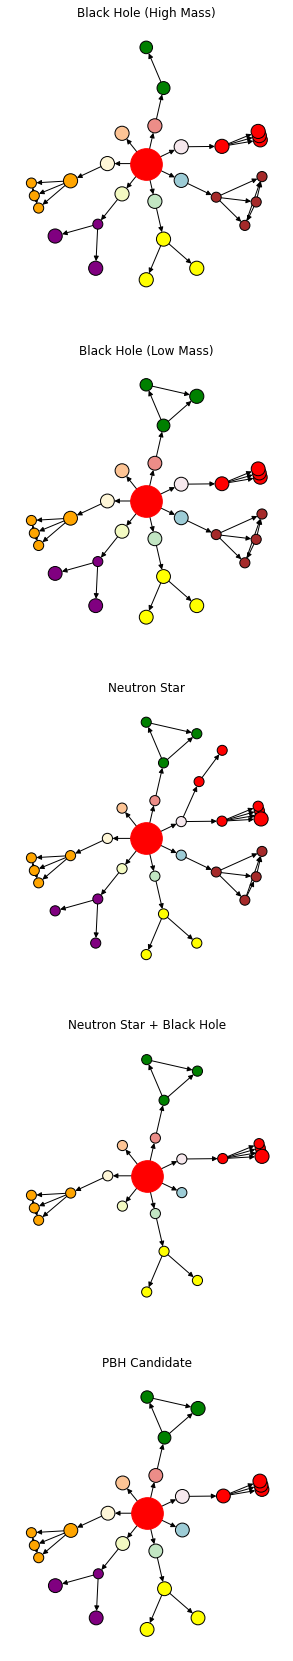

In [251]:
average_graph = {}

for c in alldf.Classification.unique():
    average_graph[c] = np.median(processed_df[alldf.Classification == c], axis=0)
    
fig, axes = plt.subplots(5,1, figsize=(5,30))

i = 0

average_rk = {}
import math
for name, data in average_graph.items():
    
    a,b = i%2, math.floor(i/2)
    ax = axes[i]
    print(a,b)
    data = pd.DataFrame(data)
    data.index = processed_df.columns
    data = data.T
    data = data.iloc[0]
    base = hft.transform(data)
    rkm = pipeline.transform(base, is_base=False)
    
    average_rk[name] = rkm
    spread = 1
    draw_rk_diagram2(rkm, ax=ax, with_labels=False,
                     spread=1, 
                     center_color=colors[le[idx]],
                     xoff=pos[0]*spread, 
                     yoff=pos[1]*spread, 
                     minsize=100, alpha=100, 
                     emult=5, make_axis=False) 
    
    i+=1
    ax.set_title(name)
plt.show()
    
    

In [302]:
import itertools
from rktoolkit.functions.distance import mahalanobis, jaccard

dist = []
for a, b in itertools.combinations(average_rk, 2):
    ag, bg = average_rk[a].get(), average_rk[b].get()
    vdist = distance.cosine(average_graph[a], average_graph[b])
    edist = jaccard(ag.nodes, bg.nodes)
    #edist = ag.edge_distance(bg)
    dist.append([a,b, edist, vdist, (vdist+edist)/2, 1-((vdist+edist)/2)])
    
pd.DataFrame(dist, columns=["Class 1", "Class 2", "Topological Distance", "Value Distance", "Average Distance", "Average Similarity"])

,Class 1,Class 2,Topological Distance,Value Distance,Average Distance,Average Similarity
0,Black Hole (High Mass),Black Hole (Low Mass),0.034483,1.432188e-12,0.017241,0.982759
1,Black Hole (High Mass),Neutron Star,0.125000,3.149037e-12,0.062500,0.937500
2,Black Hole (High Mass),Neutron Star + Black Hole,0.300000,2.543632e-12,0.150000,0.850000
3,Black Hole (High Mass),PBH Candidate,0.172414,2.025491e-12,0.086207,0.913793
4,Black Hole (Low Mass),Neutron Star,0.093750,3.500533e-13,0.046875,0.953125
5,Black Hole (Low Mass),Neutron Star + Black Hole,0.266667,1.689759e-13,0.133333,0.866667
6,Black Hole (Low Mass),PBH Candidate,0.137931,5.484502e-14,0.068966,0.931034
7,Neutron Star,Neutron Star + Black Hole,0.281250,3.297362e-14,0.140625,0.859375
8,Neutron Star,PBH Candidate,0.218750,1.281197e-13,0.109375,0.890625
9,Neutron Star + Black Hole,PBH Candidate,0.153846,3.175238e-14,0.076923,0.923077
